In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gendered-abuse-dataset/uli_dataset-main/LICENSE
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/README.md
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_en_l2.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_ta_l1.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_hi_l3.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_hi_l1.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_en_l1.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_hi_l2.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_ta_l2.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_ta_l3.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/training/train_en_l3.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/testing/test_hi_l1.csv
/kaggle/input/gendered-abuse-dataset/uli_dataset-main/testing/test_ta_l2.csv
/kaggle/i

# Hate and Offensive Speech

## Steps
1) preprocessing 2) splitting 3) tokenize & padding 4) Create model & train 5) evaluate

## Preprocessing (cleaning the datasets)
1) remove html entity 2) change user tags (@xxx -> user) 3) remove urls 4) remove unnecessary symbol ('', !, ", ') -> cause a lot of noise in the dataset 5) remove stopwords

## Model Training
1) LSTM Sequential model

## Evaluation
1) F1 score, Accuracy, Loss, Precision, Recall

# LSTM

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load data
data = pd.read_csv("/kaggle/input/hate-speech-offensive/train.csv")
print(f"num of tweets: {data.shape}")

# Extract text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

# Stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

# Cleaning functions
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    return re.sub(entity_regex, "", raw_text)

def change_user(raw_text):
    regex = r"@([^ ]+)"
    return re.sub(regex, "user", raw_text)

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    return re.sub(url_regex, '', raw_text)

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '').replace("'", '').replace("!", '').replace("`", '').replace("..", '')
    return text

def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    return " ".join(text)

def preprocess(datas):
    clean = [change_user(text) for text in datas]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]
    return clean

# Preprocess data
clean_tweet = preprocess(tweet)
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Vocabulary size and padding
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(seq) for seq in X_train)

for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

# Performance metrics
def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2 * ((precisions * recalls) / (precisions + recalls + tf.keras.backend.epsilon()))

# Model architecture
output_dim = 200
from tensorflow.keras.regularizers import l2
model = Sequential([
    Embedding(vocab_size, output_dim, input_length=max_length),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation="softmax"),
])

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1, precision, recall])
model_history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test)
)

model.summary()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate', 'offensive', 'neither'],
            yticklabels=['hate', 'offensive', 'neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['hate', 'offensive', 'neither']))


# Plotting
hist = model_history.history
plt.plot(hist['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
data.head()

# BERT

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset
data = pd.read_csv("/kaggle/input/hate-speech-offensive/train.csv")
print("num of tweets:", data.shape)

# Preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return " ".join(tokens)

# Apply preprocessing to the 'tweet' column
data['tweet'] = data['tweet'].astype(str)
data['tweet'] = data['tweet'].apply(preprocess)

# Encode labels (0=hate, 1=offensive, 2=neither — adjust if needed)
labels = to_categorical(data['class'].values)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the tweets
max_len = 128
tokens = tokenizer(
    list(data['tweet']),
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

# Load BERT model
bert = TFBertModel.from_pretrained('bert-base-uncased')

# Build model
input_ids_in = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask_in = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

def get_bert_pooled_output(inputs):
    return bert(inputs[0], attention_mask=inputs[1])[1]

bert_output = Lambda(
    get_bert_pooled_output,
    output_shape=(768,),
    name='bert_pooled_output'
)([input_ids_in, attention_mask_in])

x = Dropout(0.3)(bert_output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=[input_ids_in, attention_mask_in], outputs=output)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train model
history = model.fit(
    [input_ids, attention_mask],
    labels,
    epochs=3,
    batch_size=32,
    validation_split=0.1
)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy and loss
def plot_history(history):
    # Accuracy
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on validation set
val_size = int(0.1 * len(input_ids))
X_val_ids = input_ids[-val_size:]
X_val_mask = attention_mask[-val_size:]
y_val_true = labels[-val_size:]

# Predict class probabilities
y_pred_probs = model.predict([X_val_ids, X_val_mask], batch_size=32)

# Convert to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_true, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['hate', 'offensive', 'neither']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate', 'offensive', 'neither'],
            yticklabels=['hate', 'offensive', 'neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Bidirectional LSTM with Attention Mechanism (Fasttext Embeddings)

num of tweets: (24783, 6)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Original class distribution in training set:
1    15358
2     3328
0     1140
Name: count, dtype: int64
After augmentation, class distribution:
0    15358
2    15358
1    15358
Name: count, dtype: int64
Vocabulary Size: 24172 Max sequence length: 28
Loaded FastText embeddings: 999994


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1744729172.479537    1642 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744729172.480246    1642 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 28, 300)        │      7,251,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 28, 128)        │        186,880 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 28, 1)          │            129 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 28)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 28)             │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 28, 1)          │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 28, 128)        │              0 │ bidirectional[0][0],   │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128)            │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │            195 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,447,060 (28.41 MB)

 Trainable params: 195,460 (763.52 KB)

 Non-trainable params: 7,251,600 (27.66 MB)

Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 90s 57ms/step - accuracy: 0.4947 - loss: 1.1244 - val_accuracy: 0.8362 - val_loss: 0.6616
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.6486 - loss: 0.8227 - val_accuracy: 0.7894 - val_loss: 0.6080
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.7132 - loss: 0.7223 - val_accuracy: 0.8172 - val_loss: 0.5438
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.7483 - loss: 0.6581 - val_accuracy: 0.8180 - val_loss: 0.4956
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.7633 - loss: 0.6202 - val_accuracy: 0.8164 - val_loss: 0.5013
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.7857 - loss: 0.5719 - val_accuracy: 0.7799 - val_loss: 0.5676
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.7924 - loss: 0.5574 - val_accuracy: 0.8104 - val_loss: 0.5090


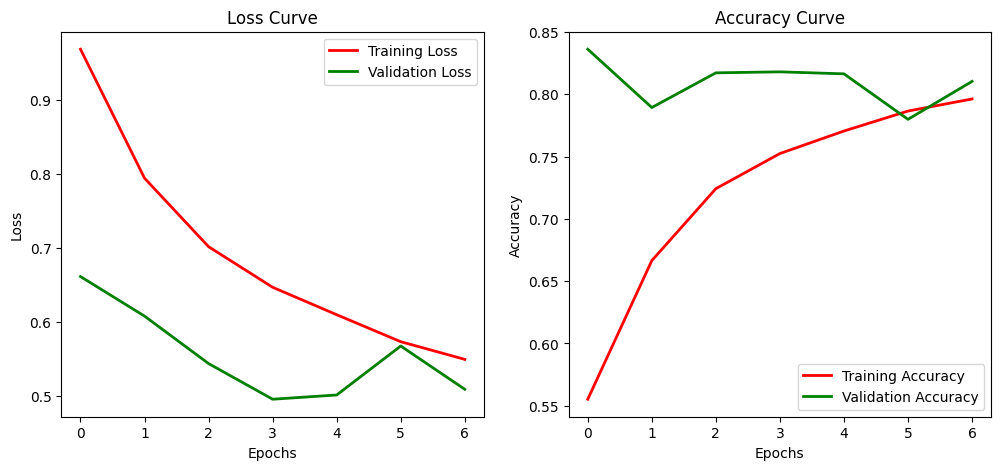

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


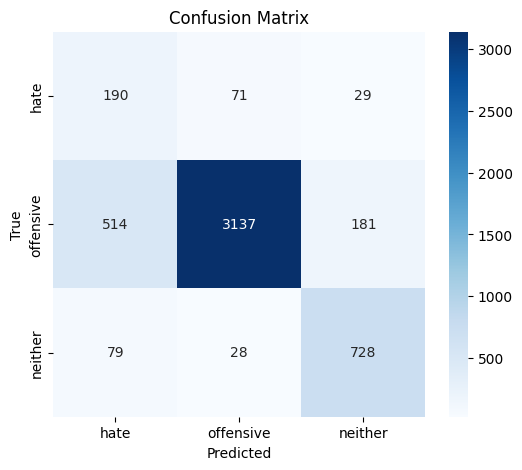

Classification Report:
              precision    recall  f1-score   support

        hate       0.24      0.66      0.35       290
   offensive       0.97      0.82      0.89      3832
     neither       0.78      0.87      0.82       835

    accuracy                           0.82      4957
   macro avg       0.66      0.78      0.69      4957
weighted avg       0.89      0.82      0.85      4957



In [9]:
!pip install scikit-learn==1.3.2 scipy==1.13.1 pandas==2.2.2 matplotlib==3.8.0 nlpaug

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten, Activation, Multiply, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nlpaug.augmenter.word as naw
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

# Load data
data = pd.read_csv("/kaggle/input/hate-speech-offensive/train.csv")
print(f"num of tweets: {data.shape}")

# Extract tweet texts and labels
tweets = data['tweet'].astype(str).tolist()
labels_int = data['class'].values  

# Define stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

# Preprocessing functions
def change_user(text):
    return re.sub(r"@([^ ]+)", "user", text)

def remove_entity(text):
    return re.sub(r"&[^\s;]+;", "", text)

def remove_url(text):
    return re.sub(r"http\S+|www\S+", "", text)

def remove_noise_symbols(text):
    return text.replace('"', '').replace("'", '').replace("!", '').replace("`", '').replace("..", '')

def remove_stopwords(text):
    tokens = word_tokenize(text)
    return " ".join([w for w in tokens if w.lower() not in stop_words])

def preprocess(text):
    text = change_user(text)
    text = remove_entity(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    text = remove_stopwords(text)
    return text

# Preprocess the tweet texts
clean_tweets = [preprocess(t) for t in tweets]

# Split data into training and test sets
X_train_text, X_test_text, y_train_int, y_test_int = train_test_split(clean_tweets, labels_int, test_size=0.2, random_state=42)
y_test = to_categorical(y_test_int, num_classes=3)

# Data Augmentation with Synonym Replacement
aug = naw.SynonymAug(aug_src='wordnet')

# Get original class distribution in training set
class_counts = pd.Series(y_train_int).value_counts()
print("Original class distribution in training set:")
print(class_counts)

# Find the majority class count
max_count = class_counts.max()

# Initialize lists to hold augmented data
augmented_texts = []
augmented_labels = []

# Augment minority classes
for cls in class_counts.index:
    if class_counts[cls] < max_count:
        num_to_generate = max_count - class_counts[cls]
        cls_indices = np.where(y_train_int == cls)[0]
        augment_indices = np.random.choice(cls_indices, size=num_to_generate, replace=True)
        for idx in augment_indices:
            original_text = X_train_text[idx]
            augmented_text = aug.augment(original_text)[0]
            augmented_texts.append(augmented_text)
            augmented_labels.append(cls)

# Combine original and augmented training data
X_train_aug = X_train_text + augmented_texts
y_train_aug_int = np.concatenate([y_train_int, augmented_labels])

# Verify the new class distribution
print("After augmentation, class distribution:")
print(pd.Series(y_train_aug_int).value_counts())

# Tokenize the augmented training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_aug)
X_train_seq = tokenizer.texts_to_sequences(X_train_aug)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(seq) for seq in X_train_seq)
print("Vocabulary Size:", vocab_size, "Max sequence length:", max_length)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Convert augmented labels to one-hot encoding
y_train_aug = to_categorical(y_train_aug_int, num_classes=3)

# Load FastText embeddings and create embedding matrix
embedding_dim = 300
embedding_index = {}
fasttext_path = "/kaggle/input/fasttext-embeddings/wiki-news-300d-1M-subword.vec"

with open(fasttext_path, encoding='utf-8', errors='ignore') as f:
    first_line = f.readline()
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print("Loaded FastText embeddings:", len(embedding_index))

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[index] = vector
    else:
        embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Build Model: Bidirectional LSTM with Attention
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], input_length=max_length, 
                           trainable=False)(inputs)

bilstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)

# Attention mechanism
attn_scores = Dense(1, activation='tanh')(bilstm)
attn_scores_flat = Flatten()(attn_scores)
attn_weights = Activation('softmax')(attn_scores_flat)
attn_weights_expanded = Lambda(lambda x: tf.expand_dims(x, -1))(attn_weights)

context_vector = Multiply()([bilstm, attn_weights_expanded])
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

x = Dropout(0.5)(context_vector)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Set up Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile and Train the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_history = model.fit(
    X_train_pad,
    y_train_aug,
    batch_size=32,
    epochs=10,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop]
)

# Plot Training History
hist = model_history.history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist['loss'], 'r', linewidth=2, label='Training Loss')
plt.plot(hist['val_loss'], 'g', linewidth=2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], 'r', linewidth=2, label='Training Accuracy')
plt.plot(hist['val_accuracy'], 'g', linewidth=2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Evaluate Model: Confusion Matrix and Classification Report
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate', 'offensive', 'neither'],
            yticklabels=['hate', 'offensive', 'neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['hate', 'offensive', 'neither']))

num of tweets: (24783, 6)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Original class distribution in training set:
1    15358
2     3328
0     1140
Name: count, dtype: int64
After augmentation, class distribution:
0    15358
2    15358
1    15358
Name: count, dtype: int64
Vocabulary Size: 24022 Max sequence length: 27
Loaded FastText embeddings: 999994


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 27)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 27, 300)        │      7,206,600 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 27, 128)        │        186,880 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 27, 128)        │        263,808 │ bidirectional_3[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ multi_head_attention_… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 3)              │            195 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,665,739 (29.24 MB)

 Trainable params: 459,139 (1.75 MB)

 Non-trainable params: 7,206,600 (27.49 MB)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Epoch 1/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - accuracy: 0.5399 - loss: 1.1614 - val_accuracy: 0.7967 - val_loss: 0.6372
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.7270 - loss: 0.6806 - val_accuracy: 0.8243 - val_loss: 0.5185
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.7961 - loss: 0.5303 - val_accuracy: 0.8029 - val_loss: 0.5332
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.8208 - loss: 0.4770 - val_accuracy: 0.8223 - val_loss: 0.4835
Epoch 5/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8290 - loss: 0.4486 - val_accuracy: 0.8269 - val_loss: 0.4796
Epoch 6/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8458 - loss: 0.4162 - val_accuracy: 0.8699 - val_loss: 0.3906
Epoch 7/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.8473 - loss: 0.4094 - val_accuracy: 0.8047 - val_loss: 0.5324
Epoch 8/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/s

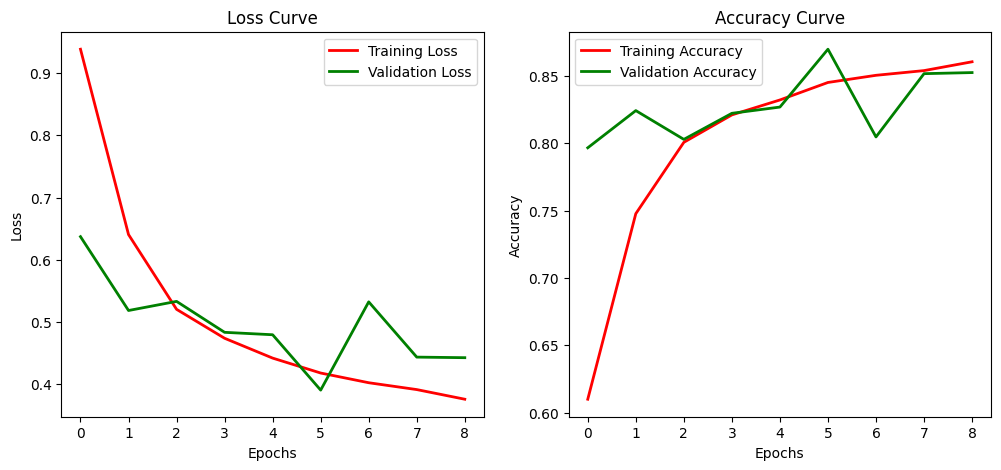

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


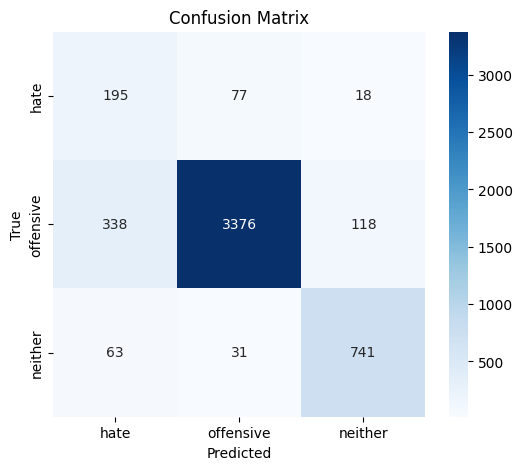

Classification Report:
              precision    recall  f1-score   support

        hate       0.33      0.67      0.44       290
   offensive       0.97      0.88      0.92      3832
     neither       0.84      0.89      0.87       835

    accuracy                           0.87      4957
   macro avg       0.71      0.81      0.74      4957
weighted avg       0.91      0.87      0.89      4957



In [13]:
# Install required packages
!pip install scikit-learn==1.3.2 nlpaug

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nlpaug.augmenter.word as naw
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

# Load data
data = pd.read_csv("/kaggle/input/hate-speech-offensive/train.csv")
print(f"num of tweets: {data.shape}")

# Extract tweet texts and labels
tweets = data['tweet'].astype(str).tolist()
labels_int = data['class'].values  

# Define stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

# Preprocessing functions
def change_user(text):
    return re.sub(r"@([^ ]+)", "user", text)

def remove_entity(text):
    return re.sub(r"&[^\s;]+;", "", text)

def remove_url(text):
    return re.sub(r"http\S+|www\S+", "", text)

def remove_noise_symbols(text):
    return text.replace('"', '').replace("'", '').replace("!", '').replace("`", '').replace("..", '')

def remove_stopwords(text):
    tokens = word_tokenize(text)
    return " ".join([w for w in tokens if w.lower() not in stop_words])

def preprocess(text):
    text = change_user(text)
    text = remove_entity(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    text = remove_stopwords(text)
    return text

# Preprocess the tweet texts
clean_tweets = [preprocess(t) for t in tweets]

# Split data into training and test sets
X_train_text, X_test_text, y_train_int, y_test_int = train_test_split(clean_tweets, labels_int, test_size=0.2, random_state=42)
y_test = to_categorical(y_test_int, num_classes=3)

# Data Augmentation with Synonym Replacement
aug = naw.SynonymAug(aug_src='wordnet')

# Get original class distribution in training set
class_counts = pd.Series(y_train_int).value_counts()
print("Original class distribution in training set:")
print(class_counts)

# Find the majority class count
max_count = class_counts.max()

# Initialize lists to hold augmented data
augmented_texts = []
augmented_labels = []

# Augment minority classes
for cls in class_counts.index:
    if class_counts[cls] < max_count:
        num_to_generate = max_count - class_counts[cls]
        cls_indices = np.where(y_train_int == cls)[0]
        augment_indices = np.random.choice(cls_indices, size=num_to_generate, replace=True)
        for idx in augment_indices:
            original_text = X_train_text[idx]
            augmented_text = aug.augment(original_text)[0]
            augmented_texts.append(augmented_text)
            augmented_labels.append(cls)

# Combine original and augmented training data
X_train_aug = X_train_text + augmented_texts
y_train_aug_int = np.concatenate([y_train_int, augmented_labels])

# Verify the new class distribution
print("After augmentation, class distribution:")
print(pd.Series(y_train_aug_int).value_counts())

# Tokenize the augmented training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_aug)
X_train_seq = tokenizer.texts_to_sequences(X_train_aug)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(seq) for seq in X_train_seq)
print("Vocabulary Size:", vocab_size, "Max sequence length:", max_length)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Convert augmented labels to one-hot encoding
y_train_aug = to_categorical(y_train_aug_int, num_classes=3)

# Load FastText embeddings and create embedding matrix
embedding_dim = 300
embedding_index = {}
fasttext_path = "/kaggle/input/fasttext-embeddings/wiki-news-300d-1M-subword.vec"

with open(fasttext_path, encoding='utf-8', errors='ignore') as f:
    first_line = f.readline()
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print("Loaded FastText embeddings:", len(embedding_index))

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[index] = vector
    else:
        embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Build Model: Bidirectional LSTM with Enhanced Attention
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], trainable=False)(inputs)
bilstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)

# Enhanced attention with MultiHeadAttention
attn_output = MultiHeadAttention(num_heads=8, key_dim=64)(bilstm, bilstm)
context_vector = GlobalAveragePooling1D()(attn_output)

x = Dropout(0.3)(context_vector)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_aug_int), y=y_train_aug_int)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Early stopping on validation accuracy
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

# Compile and Train the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_history = model.fit(
    X_train_pad,
    y_train_aug,
    batch_size=64,
    epochs=10,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# Plot Training History
hist = model_history.history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist['loss'], 'r', linewidth=2, label='Training Loss')
plt.plot(hist['val_loss'], 'g', linewidth=2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], 'r', linewidth=2, label='Training Accuracy')
plt.plot(hist['val_accuracy'], 'g', linewidth=2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Evaluate Model: Confusion Matrix and Classification Report
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate', 'offensive', 'neither'],
            yticklabels=['hate', 'offensive', 'neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['hate', 'offensive', 'neither']))

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Save the model (default format is SavedModel format)
# This will save the full model including architecture, weights, and training config
model.save('/kaggle/working/bilstm_attn_model.h5')


In [20]:
!pip install googletrans

# Transfer Learning on Gendered Abuse

Original tokenizer not found. Recreating tokenizer using FastText vocabulary.
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - binary_accuracy: 0.5622 - loss: 0.6909 - val_binary_accuracy: 0.5683 - val_loss: 0.6703
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - binary_accuracy: 0.5654 - loss: 0.6798 - val_binary_accuracy: 0.5744 - val_loss: 0.6688
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - binary_accuracy: 0.5704 - loss: 0.6771 - val_binary_accuracy: 0.5640 - val_loss: 0.6709
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - binary_accuracy: 0.5707 - loss: 0.6750 - val_binary_accuracy: 0.5700 - val_loss: 0.6685
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - binary_accuracy: 0.5748 - loss: 0.6717 - val_binary_accuracy: 0.5676 - val_loss: 0.6694


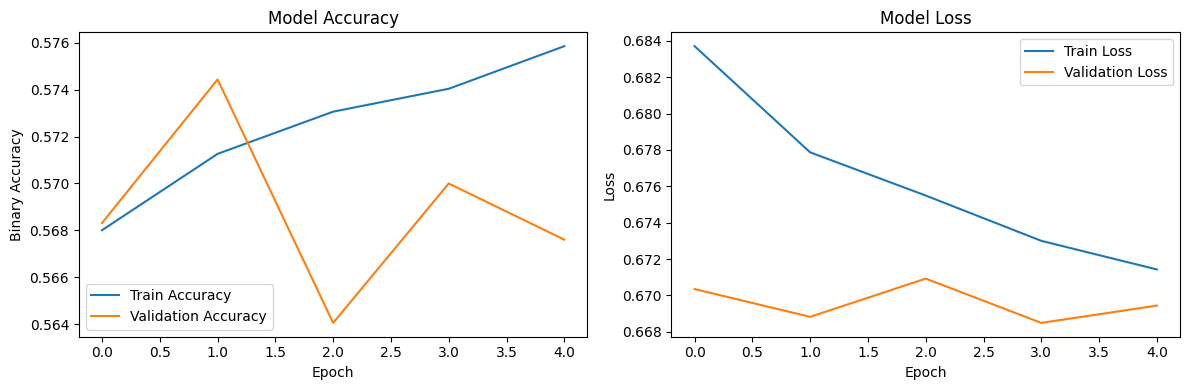

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Classification Report for l1:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      2630
           1       0.00      0.00      0.00      1125

    accuracy                           0.70      3755
   macro avg       0.35      0.50      0.41      3755
weighted avg       0.49      0.70      0.58      3755

Confusion Matrix for l1:
[[2630    0]
 [1125    0]]

Classification Report for l2:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      1897
           1       0.47      0.00      0.01      1858

    accuracy                           0.50      3755
   macro avg       0.49      0.50      0.34      3755
weighted avg       0.49      0.50      0.34      3755

Confusion Matrix for l2:
[[1888    9]
 [1850    8]]

Classification Report for l3:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      183

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options.remove("samples")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options.remove("samples")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options.remove("samples")


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import asyncio
from googletrans import Translator
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Initialize translator
translator = Translator()

# ### Step 1: Load Training and Testing Data
with open('/kaggle/input/gendered-abuse-json/final_training.json', 'r') as f:
    data_train = json.load(f)

with open('/kaggle/input/gendered-abuse-json/final_testing.json', 'r') as f:
    data_test = json.load(f)

# ### Step 2: Define Asynchronous Translation Functions
async def translate_text(text):
    """Translate a single text to English."""
    try:
        return await translator.translate(text, dest='en')
    except Exception as e:
        print(f"Translation error for text '{text}': {e}")
        return None  # Return None for failed translations

async def translate_all_texts(texts):
    """Translate a list of texts asynchronously."""
    return await asyncio.gather(*[translate_text(text) for text in texts], return_exceptions=True)

# ### Step 3: Translate All Texts
# Extract all texts from training and testing data
all_texts = [item['text'] for item in data_train] + [item['text'] for item in data_test]

# Perform translation using await (suitable for notebook event loop)
all_translations = await translate_all_texts(all_texts)

# Split translations back into training and testing sets
translations_train = all_translations[:len(data_train)]
translations_test = all_translations[len(data_train):]

# Assign translated texts to training data
for item, translation in zip(data_train, translations_train):
    item['text'] = translation.text if translation and hasattr(translation, 'text') else item['text']

# Assign translated texts to testing data
for item, translation in zip(data_test, translations_test):
    item['text'] = translation.text if translation and hasattr(translation, 'text') else item['text']

# ### Step 4: Load or Recreate the Original Tokenizer
try:
    with open('/kaggle/working/original_tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    print("Original tokenizer loaded successfully.")
except FileNotFoundError:
    print("Original tokenizer not found. Recreating tokenizer using FastText vocabulary.")
    # Load FastText embeddings to get the vocabulary
    embedding_dict = {}
    with open('/kaggle/input/fasttext-embeddings/wiki-news-300d-1M-subword.vec', 'r', encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            values = line.split()
            word = values[0]
            embedding_dict[word] = np.asarray(values[1:], dtype='float32')
    # Create a tokenizer with the FastText vocabulary
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(embedding_dict.keys())

# ### Step 5: Extract Texts and Labels
texts_train = [item['text'] for item in data_train]
labels_train = [[item['labels']['l1'], item['labels']['l2'], item['labels']['l3']] for item in data_train]
texts_test = [item['text'] for item in data_test]
labels_test = [[item['labels']['l1'], item['labels']['l2'], item['labels']['l3']] for item in data_test]

# ### Step 6: Tokenize and Pad Sequences
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
maxlen = 27  # Match the original model's expected input length
X_train_pad = pad_sequences(sequences_train, maxlen=maxlen)
X_test_pad = pad_sequences(sequences_test, maxlen=maxlen)
y_train = np.array(labels_train)
y_test = np.array(labels_test)

# ### Step 7: Load and Modify the Pre-trained Model
base_model = tf.keras.models.load_model('/kaggle/working/bilstm_attn_model.h5')
base_output = base_model.layers[-2].output  # Get output before the final layer
new_output = Dense(3, activation='sigmoid', name='new_output')(base_output)  # New output for 3 labels
new_model = Model(inputs=base_model.input, outputs=new_output)

# Freeze base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# ### Step 8: Compile the Model
new_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# ### Step 9: Train with Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    mode='max',
    patience=3,
    restore_best_weights=True
)
history = new_model.fit(
    X_train_pad,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop]
)

# ### Step 10: Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ### Step 11: Evaluate on Test Set
y_pred = new_model.predict(X_test_pad)
y_pred_binary = (y_pred > 0.5).astype(int)

# ### Step 12: Classification Report and Confusion Matrix
for i, label_name in enumerate(['l1', 'l2', 'l3']):
    print(f"\nClassification Report for {label_name}:")
    print(classification_report(y_test[:, i], y_pred_binary[:, i]))
    print(f"Confusion Matrix for {label_name}:")
    print(confusion_matrix(y_test[:, i], y_pred_binary[:, i]))

# ### Step 13: Save the Fine-tuned Model
new_model.save('/kaggle/working/gendered_abuse_model.h5')